In [1]:
from Higgs.tools.ImplementationUtils import readHEPDataCsv, implementMeasurement
from Higgs.tools.MeasurementValidation import *
from ggCorrelations import ggTheoryCorrMat
import Higgs.signals as HS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# from pdg 2020
br_Z_hadr = 69.911e-2
br_Z_ll = 2 * 3.3658e-2
br_W_hadr = 67.41e-2
br_W_lnu = 2 * 10.86e-2


## ATLAS `H->ZZ` STXS 139fb-1 [2004.03447](https://arxiv.org/abs/2004.03447)

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1790250/Table%2008%20-%20STXS%20Results/1/csv"
)


def regulariseBinName(name):
    table = {ord(c): None for c in ("$", "_", "{", "}", "^")}
    table[ord("-")] = ord("_")
    return name.translate(table)


df = (
    dfs[0]
    .iloc[5:]
    .set_index("Production bin")
    .rename(
        index=regulariseBinName,
        columns={
            "Cross section $(\sigma \cdot BR)$ SM expected [pb]": "exp",
            "error +": "exp+",
            "error -": "exp-",
        },
    )
    .reset_index()
)
df["exp+"] += df.exp
df["exp-"] += df.exp
dfObs = dfs[1].iloc[5:].reset_index(drop=True)
df["obs"] = dfObs["Cross section $(\sigma \cdot BR)$ Observed [pb]"]

# no combined uncertainties in the HEPData, so use the ones from Fig. 10c
df["obs+"] = 1e-3 * np.array([55, 110, 80, 50, 16, 75, 21, 35, 64, 7.9, 28, 26])
df["obs-"] = -1e-3 * np.array([55, 110, 80, 50, 12, 75, 16, 35, 52, 4.8, 18, 17])
df["obs+"] += df.obs
df["obs-"] += df.obs

bins = {
    name: {
        "ref": [r["exp-"], r["exp"], r["exp+"]],
        "obs": [r["obs-"], r["obs"], r["obs+"]],
    }
    for name, r in df.set_index("Production bin").iterrows()
}
for name, dat in bins.items():
    if name.startswith("gg2H"):
        dat["process"] = {"channels": [["H", "ZZ"]]}
    elif "VH" in name:
        dat["process"] = {"channels": [["HZ", "ZZ"], ["HW", "ZZ"]]}
    elif name == "ttH":
        dat["process"] = {"channels": [[p, "ZZ"] for p in ["Htt", "Ht", "HtW"]]}
    else:
        dat["process"] = {"channels": [["vbfH", "ZZ"]]}
bins["qq2Hqq_VH"]["channelWeights"] = [br_Z_hadr, br_W_hadr]
bins["VH_Lep"]["channelWeights"] = [br_Z_ll, br_W_lnu]

dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1790250/Figure%2010d%20-%20Correlation%20Matrix%20for%20Reduced%20Stage%201.1/1/csv"
)
corrMat = (
    pd.concat([df.set_index("Reduced Stage1.1 BIN []") for df in dfs], axis=1)
    .rename(index=regulariseBinName, columns=regulariseBinName)
    .drop(["ZZ_0j", "ZZ_1j", "ZZ_2j", "tXX"])
    .drop(["ZZ_0j", "ZZ_1j", "ZZ_2j", "tXX"], axis=1)
)

corrMatTheo = ggTheoryCorrMat(
    {b: "0j" for b in corrMat.index if b.startswith("gg2H_0j_pTH")}
    | {
        "gg2H_1j_pTH_Low": "1j_0_60",
        "gg2H_1j_pTH_Med": "1j_60_120",
        "gg2H_1j_pTH_High": "1j_120_200",
        "gg2H_2j": ">=2j",
        "gg2H_pTH_High": ">=1j_>200",
    },
    corrMat,
)
measFile = implementMeasurement(
    "2004.03447",
    "https://doi.org/10.17182/hepdata.94311.v1/t25, https://doi.org/10.17182/hepdata.94311.v1/t27, http://dgillber.web.cern.ch/dgillber/ggF_uncertainty_2017/corr2017.pdf",
    bins,
    prefix="ZZ_4l_STXS",
    corrMatExp=corrMat,
    corrMatTheo=corrMatTheo,
    referenceMass=125,
    massResolution=2.5,
)


Looks good. Saving this to ZZ_4l_STXS_LHC13_ATLAS_139.json


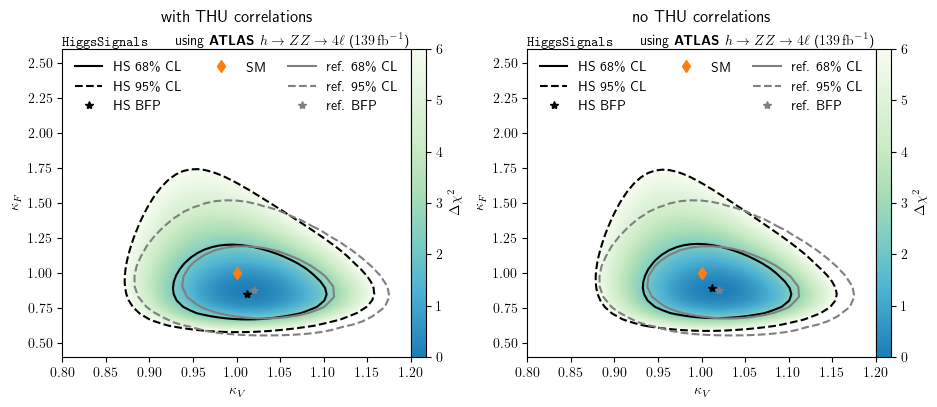

In [3]:
description = r"$h\to ZZ\to 4\ell$"
official68Dat = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1790250/Figure%2012%20-%20%24%5Ckappa_%7BV%7D%24vs.%24%5Ckappa_%7BF%7D%24%2068%25%20CLs/1/csv"
)
official68 = (official68Dat[0].iloc[1:, 0], official68Dat[0].iloc[1:, 1])
official95Dat = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1790250/Figure%2012%20-%20%24%5Ckappa_%7BV%7D%24vs.%24%5Ckappa_%7BF%7D%24%2095%25%20CLs/1/csv"
)
official95 = (official95Dat[0].iloc[1:, 0], official95Dat[0].iloc[1:, 1])
officialBF = official95Dat[0].iloc[0, :].to_numpy()
plt.rc("text", usetex=True)


kappaF = np.linspace(0.4, 2.6)
kappaV = np.linspace(0.8, 1.2)

fig, axs = plt.subplots(ncols=2, figsize=(11, 4))

axs[0].set_title("with THU correlations", pad=20)
validateMeasurementKappa(
    HS.Measurement(measFile),
    kappaF,
    kappaV,
    description,
    official={95: official95, 68: official68, "BF": officialBF},
    fig=fig,
    ax=axs[0],
)

axs[1].set_title("no THU correlations", pad=20)
validateMeasurementKappa(
    HS.Measurement(
        measFile, HS.MeasurementOptions(whichCorrelations="experimentalOnly")
    ),
    kappaF,
    kappaV,
    description,
    official={95: official95, 68: official68, "BF": officialBF},
    fig=fig,
    ax=axs[1],
)
plt.show()


## CMS `H>ZZ` STXS 137fb-1 [2103.04956](http://arxiv.org/abs/2103.04956)


This is the implementation of the merged stage 1.2 STXS. Using the v4 HEPdata entry, the validation plots now look reasonable.

In [8]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1850544/STXS%20Stage%201.2%20cross%20sections/4/csv"
)


def regulariseBinName(name):
    table = {ord(c): None for c in ("$", "_", "{", "}", "^", "]")}
    table[ord("-")] = ord("_")
    table[ord("[")] = ord("_")
    table[ord(",")] = ord("_")
    table[ord("/")] = ord("_")
    table[ord(">")] = ord("_")
    return name[8:].translate(table)


df = 1e-3 * pd.concat(
    [df.set_index("STXS region").rename(index=regulariseBinName) for df in dfs[:-1]],
    axis=1,
).rename(
    columns={
        "SM predicted cross section times branching ratio [fb]": "ref",
        "Theory +": "ref+",
        "Theory -": "ref-",
        "Observed cross section times branching ratio [fb]": "obs",
        "Total +": "obs+",
        "Total -": "obs-",
    },
)

df["ref+"] += df["ref"]
df["ref-"] += df["ref"]
df["obs+"] += df["obs"]
df["obs-"] += df["obs"]

# define the bins
bins = {
    name: {
        "ref": [r["ref-"], r["ref"], r["ref+"]],
        "obs": [r["obs-"], r["obs"], r["obs+"]],
    }
    for name, r in df.iterrows()
}
for name, dat in bins.items():
    if name == "ggH_0j_pT_10_200":
        dat["process"] = {
            "channels": [["H", "ZZ"]]
        }  # p. 11, bbH is classified into this single bin
    elif name.startswith("ggH"):
        dat["process"] = {"channels": [["ggH", "ZZ"]]}
    elif name.startswith("VH"):
        dat["process"] = {"channels": [["HZ", "ZZ"], ["HW", "ZZ"]]}
        dat["channelWeights"] = [br_Z_ll, br_W_lnu]
    elif name == "qqH_2j_mjj_60_120":  # this bin targets VH hadr (see STXS paper)
        dat["process"] = {"channels": [["HZ", "ZZ"], ["HW", "ZZ"]]}
        dat["channelWeights"] = [br_Z_hadr, br_W_hadr]
    elif name == "ttH":
        dat["process"] = {"channels": [[p, "ZZ"] for p in ["Htt", "Ht", "HtW"]]}
    else:
        dat["process"] = {"channels": [["vbfH", "ZZ"]]}

# experimental correlation matrix
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1850544/Correlations%3A%20STXS%20Stage%201.2%20cross%20sections/4/csv"
)


corrmatExp = pd.concat(
    [
        v.droplevel(0).rename(columns={"Observed correlation": k})
        for k, v in dfs[0]
        .set_index(["STXS region (x)", "STXS region (y)"])
        .rename(index=regulariseBinName)
        .groupby("STXS region (x)")
    ],
    axis=1,
)

dc1 = {b: "0j" for b in corrmatExp.index if b.startswith("ggH_0j_pT")}
dc2 = {b: "1j_" + b[10:] for b in corrmatExp.index if b.startswith("ggH_1j_pT")}
dc3 = {b: ">=2j_" + b[10:] for b in corrmatExp.index if b.startswith("ggH_2j_pT")}
dc4 = {"ggH_pT_200": ">=1j_>200"}
dcc = dict(dc1, **dc2)
dcc = dict(dcc, **dc3)
dcc = dict(dcc, **dc4)
corrmatTheo = ggTheoryCorrMat(
    dcc,
    corrmatExp)

measFile = implementMeasurement(
    "2103.04956",
    "https://doi.org/10.17182/hepdata.102525.v4/t11, https://doi.org/10.17182/hepdata.102525.v4/t13, http://dgillber.web.cern.ch/dgillber/ggF_uncertainty_2017/corr2017.pdf",
    bins,
    prefix="ZZ_4l_STXS",
    corrMatExp=corrmatExp,
    corrMatTheo=corrmatTheo,
    referenceMass=125.38,
    massResolution=2.5,
)

Looks good. Saving this to ZZ_4l_STXS_LHC13_CMS_137.json


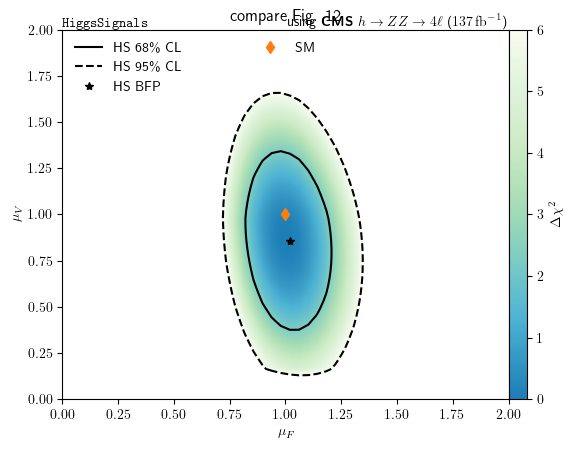

In [9]:
description = r"$h\to ZZ\to 4\ell$"

muF = np.linspace(0, 2)
muV = np.linspace(0, 2)


def modFacs(muF, muV):
    modFacs = {
        x: 5 * [muF] if x.startswith("ggH") or x == "ttH" else 5 * [muV]
        for x in bins.keys()
    }
    return modFacs


fig, ax = validateMeasurementModFactors(
    HS.Measurement(measFile), muF, muV, modFacs, description
)
ax.plot(1, 1, marker="d", c="tab:orange", ls="none", label="SM")
ax.legend(loc="upper center", frameon=False)

ax.set_title("compare Fig. 12")
ax.set_xlabel(r"$\mu_{F}$")
ax.set_ylabel(r"$\mu_{V}$")
plt.savefig('2103.04956Fig12.pdf')